In [3]:
import os
import tensorflow as tf
from PIL import Image
from nets import nets_factory   
import numpy as np

In [4]:
CAHR_SET_LEN = 10
IMAGE_HEIGHT, IMAGE_WIDTH = 60, 100
BATCH_SIZE = 25 
TFRECORD_FILE = 'captcha/train.tfrecords'

x = tf.placeholder(tf.float32,[None,224,224])
y0 = tf.placeholder(tf.float32,[None])
y1 = tf.placeholder(tf.float32,[None])
y2 = tf.placeholder(tf.float32,[None])
y3 = tf.placeholder(tf.float32,[None])

lr = tf.Variable(0.003, dtype = tf.float32)

def read_and_decode(filename):
    filename_queue = tf.train.string_input_producer([filename])
    reader = tf.TFRecordReader()
    
    # get filenames(labels)
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example,
                                      features = {
                                      'image': tf.FixedLenFeature([],tf.string),
                                      'label0': tf.FixedLenFeature([],tf.int64),
                                      'label1': tf.FixedLenFeature([],tf.int64),
                                      'label2': tf.FixedLenFeature([],tf.int64),
                                      'label3': tf.FixedLenFeature([],tf.int64) 
                                 })
    
    
    image = tf.decode_raw(features['image'],tf.uint8)
    
      
    image = tf.reshape(image,[224,224])    
    image = tf.cast(image,tf.float32) / 255.0
    image = tf.subtract(image,0.5)
    image = tf.multiply(image,2.0)
    
    label0 = tf.cast(features['label0'],tf.int32)
    label1 = tf.cast(features['label1'],tf.int32)
    label2 = tf.cast(features['label2'],tf.int32)
    label3 = tf.cast(features['label3'],tf.int32)

    return image, label0, label1, label2, label3

In [5]:
image, label0, label1, label2, label3 = read_and_decode(TFRECORD_FILE)

# divide batches(shuffle)
image_batch, label_batch0, label_batch1, label_batch2, label_batch3 = tf.train.shuffle_batch(
        [image, label0, label1,label2,label3], batch_size = BATCH_SIZE,
        capacity = 50000, min_after_dequeue = 10000, num_threads = 1)

train_network_fn = nets_factory.get_network_fn(
    'alexnet_v2',
    num_classes = CAHR_SET_LEN,
    weight_decay = 0.0005,
    is_training = True)

with tf.Session() as sess:    

    #inputs: a tensor of size[batch_size, height, width,channels]
    
    X = tf.reshape(x,[BATCH_SIZE, 224, 224, 1])
    
    # forward pass 
    logits0, logits1, logits2, logits3, end_points = train_network_fn(X)

    # one-hot encoder
    one_hot_labels0 = tf.one_hot(indices = tf.cast(y0,tf.int32), depth = CAHR_SET_LEN)
    one_hot_labels1 = tf.one_hot(indices = tf.cast(y1,tf.int32), depth = CAHR_SET_LEN)
    one_hot_labels2 = tf.one_hot(indices = tf.cast(y2,tf.int32), depth = CAHR_SET_LEN)
    one_hot_labels3 = tf.one_hot(indices = tf.cast(y3,tf.int32), depth = CAHR_SET_LEN)

    # compute loss
    loss0 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits0, labels = one_hot_labels0))
    loss1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits1, labels = one_hot_labels1))
    loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits2, labels = one_hot_labels2))
    loss3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits3, labels = one_hot_labels3))    
    total_loss = (loss0 + loss1 + loss2 + loss3) / 4.0

    # define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(total_loss)

    # accuracy
    correct_prediction0 = tf.equal(tf.argmax(one_hot_labels0, 1), tf.argmax(logits0, 1))
    accuracy0 = tf.reduce_mean(tf.cast(correct_prediction0, tf.float32))

    correct_prediction1 = tf.equal(tf.argmax(one_hot_labels1, 1), tf.argmax(logits1, 1))
    accuracy1 = tf.reduce_mean(tf.cast(correct_prediction1, tf.float32))

    correct_prediction2 = tf.equal(tf.argmax(one_hot_labels2, 1), tf.argmax(logits2, 1))
    accuracy2 = tf.reduce_mean(tf.cast(correct_prediction2, tf.float32))

    correct_prediction3 = tf.equal(tf.argmax(one_hot_labels3, 1), tf.argmax(logits3, 1))
    accuracy3 = tf.reduce_mean(tf.cast(correct_prediction3, tf.float32))

    losses = []
    accs0, accs1,accs2,accs3 = [],[],[],[]
    # init training 
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())    
    coord = tf.train.Coordinator()     # create coordinator for threads management   
    threads = tf.train.start_queue_runners(sess = sess, coord = coord)

    for i in range(2001):        
        b_image, b_label0, b_label1, b_label2, b_label3 = sess.run([image_batch, label_batch0, label_batch1, label_batch2, label_batch3])        
        
        sess.run(optimizer, feed_dict = {x:b_image, y0: b_label0, y1:b_label1, y2:b_label2, y3:b_label3})
        
        if i % 20 == 0:
            if i % 2000 == 0:
                sess.run(tf.assign(lr, lr/3))
            acc0, acc1, acc2, acc3, loss_ = sess.run([accuracy0,accuracy1,accuracy2,accuracy3, total_loss], feed_dict = {x:b_image, y0: b_label0, y1:b_label1, y2:b_label2, y3:b_label3})
            learning_rate = sess.run(lr)
            print("Iter: %d Loss:%.3f  Accuracy:%.2f, %.2f, %.2f, %.2f Learning Rate: %.4f" % (i, loss_, acc0, acc1,acc2,acc3, learning_rate))
            losses.append(loss_)
            accs0.append(acc0)
            accs1.append(acc1)
            accs2.append(acc2)
            accs3.append(acc3)
            
            if i == 2000:
                saver.save(sess,'./captcha/models/crack_captcha.model', global_step = i)
                break 
                
    coord.request_stop()    
    coord.join(threads)


Iter: 0 Loss:2949.960  Accuracy:0.20, 0.20, 0.20, 0.20 Learning Rate: 0.0010
Iter: 20 Loss:2.230  Accuracy:0.24, 0.24, 0.24, 0.24 Learning Rate: 0.0010
Iter: 40 Loss:2.360  Accuracy:0.00, 0.04, 0.00, 0.00 Learning Rate: 0.0010
Iter: 60 Loss:2.311  Accuracy:0.04, 0.12, 0.04, 0.08 Learning Rate: 0.0010
Iter: 80 Loss:2.309  Accuracy:0.16, 0.12, 0.12, 0.08 Learning Rate: 0.0010
Iter: 100 Loss:2.304  Accuracy:0.12, 0.12, 0.12, 0.12 Learning Rate: 0.0010
Iter: 120 Loss:2.326  Accuracy:0.00, 0.00, 0.00, 0.00 Learning Rate: 0.0010
Iter: 140 Loss:2.376  Accuracy:0.08, 0.04, 0.12, 0.12 Learning Rate: 0.0010
Iter: 160 Loss:2.314  Accuracy:0.04, 0.04, 0.04, 0.04 Learning Rate: 0.0010
Iter: 180 Loss:2.080  Accuracy:0.08, 0.12, 0.12, 0.12 Learning Rate: 0.0010
Iter: 200 Loss:1.616  Accuracy:0.48, 0.52, 0.48, 0.52 Learning Rate: 0.0010
Iter: 220 Loss:1.683  Accuracy:0.40, 0.36, 0.44, 0.44 Learning Rate: 0.0010
Iter: 240 Loss:1.157  Accuracy:0.52, 0.48, 0.52, 0.52 Learning Rate: 0.0010
Iter: 260 Loss:

In [8]:
#losses = []
#accs0, accs1,accs2,accs3 = [],[],[],[]
tt = losses[1:]
print(tt)

[2.2301197, 2.3598547, 2.311077, 2.308581, 2.3039365, 2.3258529, 2.3757904, 2.3141198, 2.0795307, 1.6164591, 1.6834997, 1.1568704, 1.2635951, 1.3433212, 1.0159931, 1.462353, 0.7240821, 0.7499572, 0.6581744, 0.75148535, 0.34728032, 0.35577905, 0.16424255, 0.47629935, 0.5071932, 0.3238995, 0.45924917, 0.5391009, 0.10538639, 0.27202177, 0.21952295, 0.27579415, 0.18184032, 0.20268415, 0.16081731, 0.21043475, 0.22090477, 0.34460354, 0.04619245, 0.14293008, 0.17554651, 0.18855599, 0.22666007, 0.07282446, 0.09476331, 0.09840326, 0.14233541, 0.0063199783, 0.16387086, 0.0091770105, 0.17466061, 0.014508199, 0.12279827, 0.08419081, 0.38340926, 0.010240983, 0.1285661, 0.08673972, 0.086084604, 0.03494567, 0.03544248, 0.06691845, 0.05435751, 0.0068038944, 0.004939341, 0.0737756, 0.12086514, 0.01397849, 0.062012076, 0.102192916, 0.032653213, 0.00039007762, 0.06975507, 0.012588463, 0.14128643, 0.0073304917, 0.07192111, 0.013116747, 0.03987263, 0.015843939, 0.005467127, 0.052928098, 0.022511542, 0.1375

In [13]:
import matplotlib.pyplot as plt

def plot_accuracy(): 
    fig,ax = plt.subplots()     
    plt.xlabel('Training epochs')  
    plt.ylabel('Accuracy') 
    x = range(len(accs0))
    #ax.set_ylim([0,0.8])  
    #ax.set_xlim([58,42])
    ax.plot(x,accs0,'g',label = 'digit-1')    
    ax.plot(x,accs1,'y',label = 'digit-2')
    ax.plot(x,accs2,'r',label = 'digit-3')
    ax.plot(x,accs3,'b',label = 'digit-4')
    plt.grid(True)  
    plt.legend(bbox_to_anchor=(1.0, 0), loc = 4, borderaxespad=0.)  
    plt.show()  
    
    
def plot_loss():
    fig,ax = plt.subplots()     
    plt.xlabel('Training epochs')  
    plt.ylabel('Loss values') 
    x = range(len(tt))
    #ax.set_ylim([0,1])  
    #ax.set_xlim([58,42])
    ax.plot(x,tt,'g',label = 'train set')    
    #ax.plot(x,loss_test,'r',label = 'test set') 
    #ax.plot(x,loss_val,'y',label = 'validation set')
    plt.grid(True)  
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc = 1, borderaxespad=0.)  
    plt.show() 

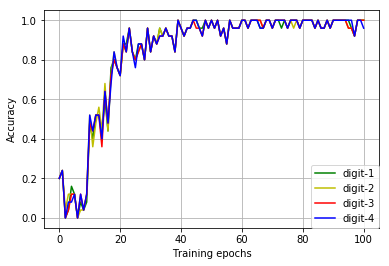

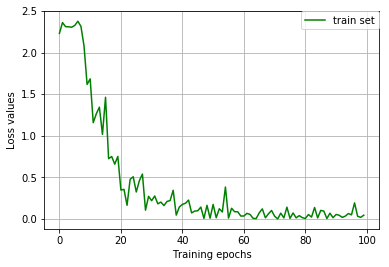

In [14]:
plot_accuracy()
plot_loss()